In [1]:
import os
import pathlib
import random
import glob
import math
import scipy.io

import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import seaborn as sns
import pandas as pd
import SimpleITK as sitk

from skimage import color, io, img_as_ubyte, img_as_float, segmentation, measure
from skimage.measure import profile_line
from skimage.transform import rescale, resize, rotate, EuclideanTransform, SimilarityTransform, warp, swirl, matrix_transform 
from skimage.morphology import erosion, dilation, opening, closing, disk, binary_closing, binary_opening
from skimage.color import label2rgb, rgb2gray, rgb2hsv
from skimage.filters import median, gaussian, prewitt_h, prewitt_v, prewitt, threshold_otsu

from sklearn import decomposition
from sklearn.decomposition import PCA

from scipy.ndimage import correlate
from scipy.stats import norm
from scipy.spatial import distance

## Image Tracing

In [2]:
def index(array, item):
    # array is 1-dimensional
    # returns index of first instance of item
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx[0]

def image_tracing(img):
    acc_img = np.zeros(img.shape)
    trace_img = np.zeros(img.shape)

    # initialise first row of accumulator image
    acc_img[0,:] = img[0,:]

    for row in range(1,img.shape[0]):
        for col in range(img.shape[1]):
            # follow 0-indexing
            min_col = max(0,col-1)
            max_col = min(img.shape[1]-1,col+1)
            min_pixel = min(acc_img[row-1,min_col],acc_img[row-1,col],acc_img[row-1,max_col])
            acc_img[row,col] = img[row,col]+min_pixel

            # change to 1-indexing
            idx = index(acc_img[row-1,:],min_pixel)
            idx = idx+1
            trace_img[row,col] = idx
    
    print("input image: \n", img)
    print("accumulator image: \n", acc_img)
    print("trace image: \n", trace_img)
    
    return acc_img, trace_img


In [3]:
# From https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html
def plot_comparison(original, filtered, filter_name):
    """
    convenience function to show two images side by side:
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    io.show()

## Score Summary
i got different answers for 6/20 questions <br>
4 of which are 'close enough'

In [4]:
in_dir = "spring2021_data/"

No. of features: 5
No. of observations: 150
cum sum:  [0.92461872 0.97768521 0.99478782 1.        ]


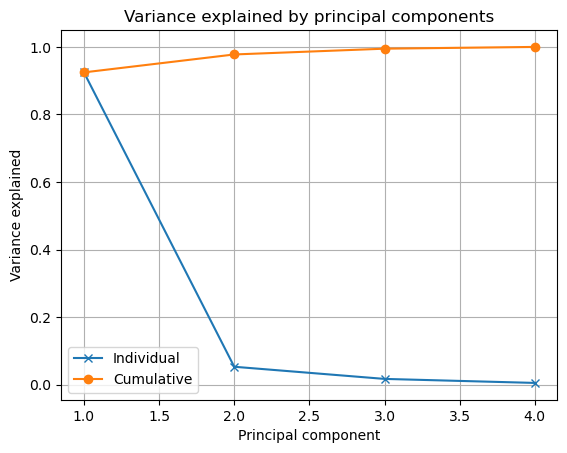

In [5]:
## Iris PCA
txt_name = "irisdata.txt"
x = np.loadtxt(in_dir + txt_name, comments="%")

# Check matric dimensions
n_feat = x.shape[1]   # columns
n_obs = x.shape[0]    # rows
print(f"No. of features: {n_feat}")
print(f"No. of observations: {n_obs}")

# Remove last column
x = x[:,0:4]

pca = decomposition.PCA()
pca.fit(x)
values_pca = pca.explained_variance_
exp_var_ratio = pca.explained_variance_ratio_
vectors_pca = pca.components_
data_transform = pca.transform(x)

print('cum sum: ',np.cumsum(exp_var_ratio))

# Plot variance explained
plt.figure()
plt.plot(range(1, len(exp_var_ratio)+1), exp_var_ratio, 'x-')
plt.plot(range(1, len(exp_var_ratio)+1), np.cumsum(exp_var_ratio), 'o-')
plt.title('Variance explained by principal components')
plt.xlabel('Principal component')
plt.ylabel('Variance explained')
plt.legend(['Individual', 'Cumulative'])
plt.grid()
plt.show()

In [6]:
data_transform[0]

array([-2.68412563e+00,  3.19397247e-01, -2.79148276e-02, -2.26243707e-03])

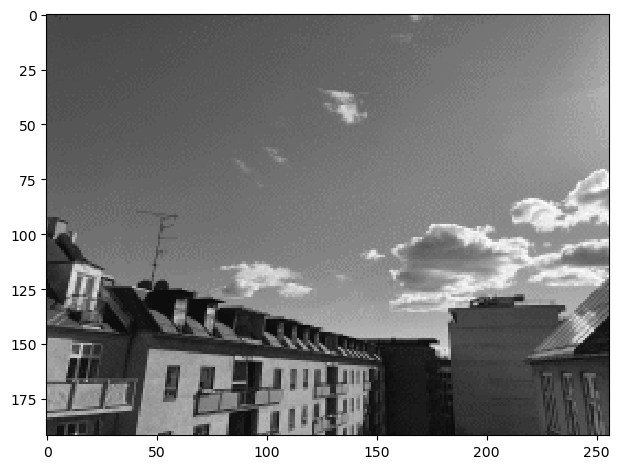

In [7]:
input_img = io.imread(in_dir + "sky_gray.png")
io.imshow(input_img)
io.show()

In [8]:
def histogram_stretch(img_in):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched according to 
             min_desired and max_desired
    """
# #     img_as_float will divide all pixel values with 255.0
#     img_float = img_as_float(img_in)
    min_val = img_in.min()
    max_val = img_in.max()
    min_desired = 10
    max_desired = 200

    # Do something here
    img_out = img_in
    for i in range(img_in.shape[0]):
        for j in range(img_in.shape[1]):
            new = (img_in[i,j] - min_val)*(max_desired - min_desired)/(max_val - min_val) + min_desired
            img_out[i,j] = new

    return img_out
#     img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
#     return img_as_ubyte(img_out)

im_stretched = histogram_stretch(input_img)
np.mean(im_stretched)


86.53926595052083

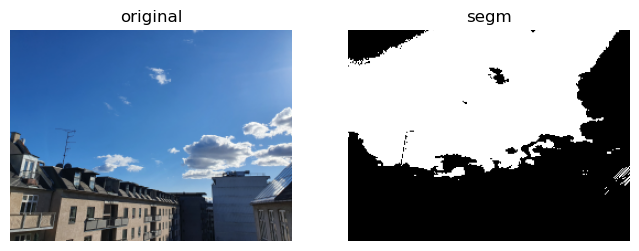

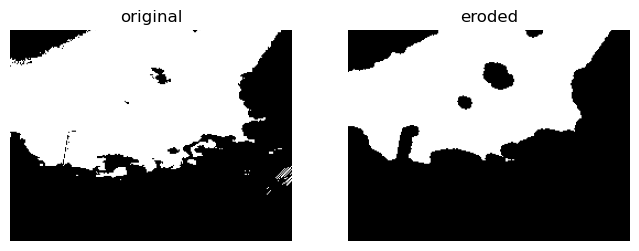

In [9]:
input_img = io.imread(in_dir + "sky.png")
r_comp = input_img[:, :, 0]
g_comp = input_img[:, :, 1]
b_comp = input_img[:, :, 2]

segm = (r_comp < 100) & (g_comp > 85) & (g_comp < 200) & (b_comp > 150)
plot_comparison(input_img,segm,'segm')

eroded = erosion(segm,disk(5))
plot_comparison(segm,eroded,'eroded')

In [10]:
np.bincount(eroded.flatten())

array([29539, 19613], dtype=int64)

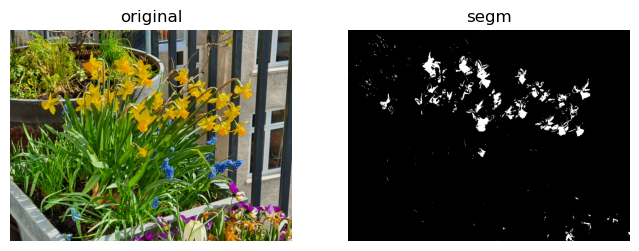

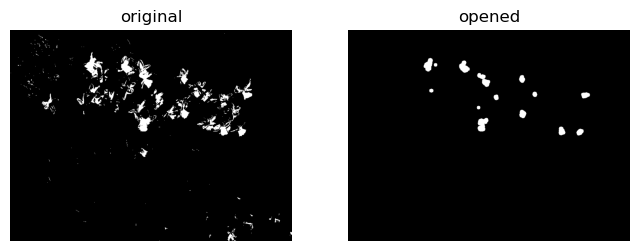

In [11]:
input_img = io.imread(in_dir + "flower.png")
hsv_img = rgb2hsv(input_img)

hue_comp = hsv_img[:, :, 0]
sat_comp = hsv_img[:, :, 1]
val_comp = hsv_img[:, :, 2]

segm = (hue_comp < 0.25) & (sat_comp > 0.8) & (val_comp > 0.8)
plot_comparison(input_img,segm,'segm')

opened = opening(segm,disk(5))
plot_comparison(segm,opened,'opened')

In [12]:
np.bincount(opened.flatten())

array([475052,   4948], dtype=int64)

In [13]:
# compute data matrix
all_images = ['car1.jpg','car2.jpg','car3.jpg','car4.jpg','car5.jpg']
all_images = [in_dir+filename for filename in all_images]
n_samples = len(all_images)

# read first image
first_img = io.imread(all_images[0])
height, width = first_img.shape
channels=1
n_features = height*width*channels

print("n_samples: ", n_samples)
print("n_features: ", n_features)

data_matrix = np.zeros((n_samples, n_features))
for idx,img_path in enumerate(all_images):
    img = io.imread(img_path)
    data_matrix[idx,:] = img.flatten()

n_samples:  5
n_features:  480000


array([4.01312445e-01, 2.73035721e-01, 1.71802917e-01, 1.53848917e-01,
       6.11176219e-29])

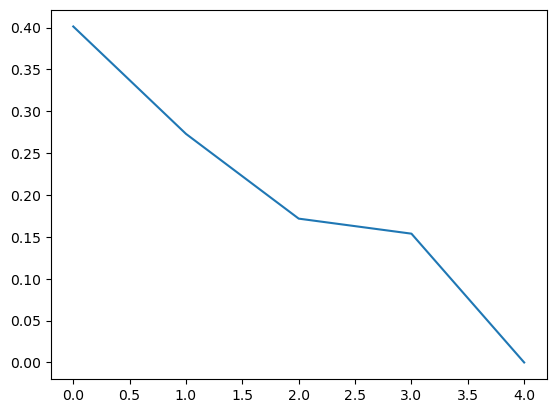

In [14]:
# PCA
pca = decomposition.PCA()
pca.fit(data_matrix)
values_pca = pca.explained_variance_
exp_var_ratio = pca.explained_variance_ratio_
vectors_pca = pca.components_
plt.plot(pca.explained_variance_ratio_)

exp_var_ratio

## Gamma mapping, median filter

In [15]:
def gamma_map(img_in, gamma):
    """
    Apply gamma mapping to an image 
    :param img_in: Input image, gamma value
    :return: Image, with gamma mapping applied
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
   
    # Do something here
    img_out = np.power(img_float,np.ones(img_float.shape)*gamma)
    
    # img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
    return img_as_ubyte(img_out)

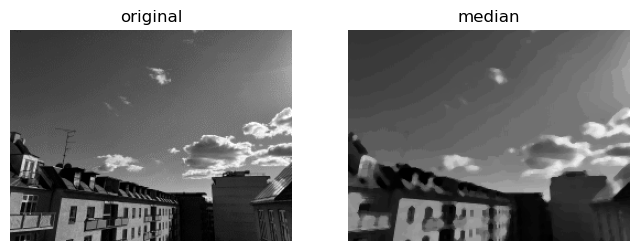

68

In [16]:
input_img = io.imread(in_dir + "sky_gray.png")

gamma_img = gamma_map(input_img,1.21)

size = 5
footprint = np.ones([size, size])
med_img = median(gamma_img, footprint)

plot_comparison(gamma_img,med_img,'median')

med_img[40,50]

## Average filter, mean filter

In [17]:
input_img = io.imread(in_dir + "flowerwall.png")
size = 15
weights = np.ones([size, size])
weights = weights / np.sum(weights)
mean_img = correlate(input_img, weights)

mean_img[5,50]

208

## Floorboards, BLOB analysis

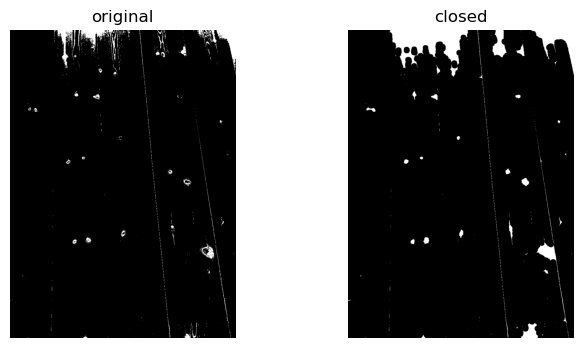

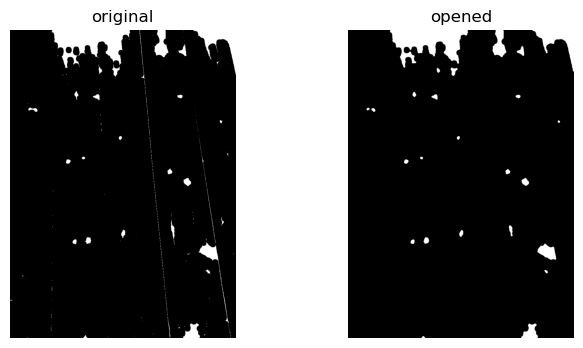

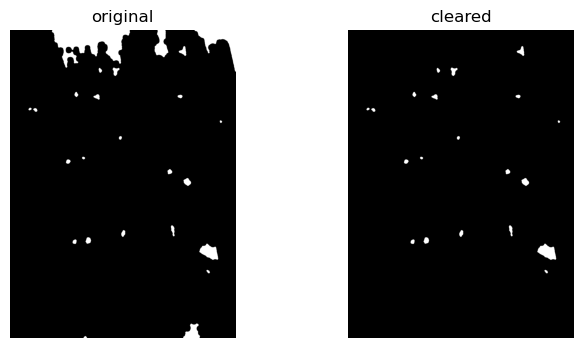

array([867109,   6491], dtype=int64)

In [20]:
input_img = io.imread(in_dir + "floorboards.png")
thres_img = input_img < 100

closed = closing(thres_img,disk(10))
plot_comparison(thres_img,closed,'closed')

opened = opening(closed,disk(3))
plot_comparison(closed,opened,'opened')

cleared = segmentation.clear_border(opened)
plot_comparison(opened,cleared,'cleared')

np.bincount(cleared.flatten())

In [21]:
label_img = measure.label(cleared)
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])

areas = [area for area in areas if (area>100)]
print(len(areas))

16


## Book Letters

In [26]:
input_img = io.imread(in_dir + "books_bw.png")
label_img = measure.label(input_img)
region_props = measure.regionprops(label_img)
# areas = np.array([prop.area for prop in region_props])
# perimeters = np.array([prop.perimeter for prop in region_props])

rgblabel_img = label2rgb(label_img)

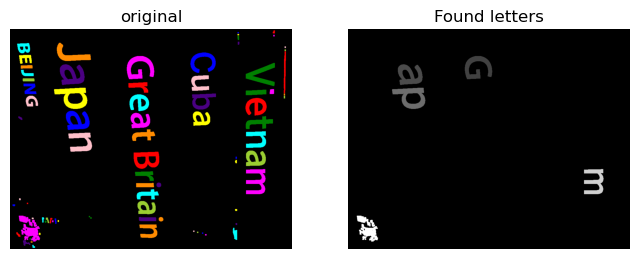

In [27]:
min_area = 100
min_peri = 500

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
    # Find the areas that do not fit our criteria
    if region.area <= min_area or region.perimeter <= min_peri:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
            
plot_comparison(rgblabel_img, label_img_filter, 'Found letters')

## Cat Transform

In [24]:
moving_mat = scipy.io.loadmat(in_dir+'catmovingPoints.mat')
fixed_mat = scipy.io.loadmat(in_dir+'catfixedPoints.mat')

src = moving_mat["movingpoints"]
dst = fixed_mat["fixedpoints"]

# compute objective function (sum of squared error)
e_x = src[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)

e_y = src[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)

f = error_x + error_y
print(f"Landmark alignment error F: {f:.2f}")

Landmark alignment error F: 46552.97


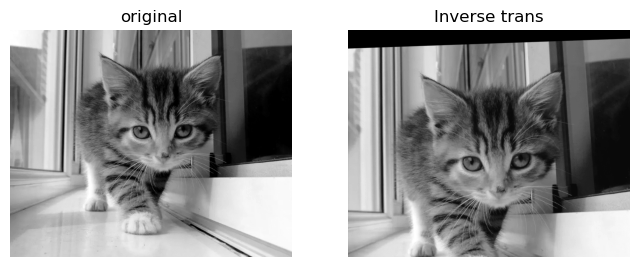

In [25]:
# Find similarity transform
tform = SimilarityTransform()
tform.estimate(src, dst)

# Apply computed transform to cat2.png
cat2 = io.imread(in_dir + 'cat2.png')
warped = warp(cat2, tform.inverse)
plot_comparison(cat2, warped, "Inverse trans")


## DICOM scan, ROI

In [28]:
# start 11.48pm
ct = dicom.read_file(in_dir + '1-179.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

(512, 512)
int16


In [29]:
# Exercise 2: use the annotated images (boolean masks)
liver_roi = io.imread(in_dir + 'LiverROI.png')
# convert to boolean image
liver_mask = liver_roi > 0
liver_values = img[liver_mask]
mu_liver = np.mean(liver_values)
std_liver = np.std(liver_values)
print(liver_values.shape)
print(mu_liver)
print(std_liver)

(3938,)
111.3621127475876
18.765720528215887


In [35]:
T1 = mu_liver - std_liver
T2 = mu_liver + std_liver
segm = (img>T1) & (img<T2)
np.bincount(segm.flatten())

array([253160,   8984], dtype=int64)

In [36]:
T1 = 90
T2 = 140
segm = (img>T1) & (img<T2)
closed = closing(segm, disk(3))
opened = opening(closed, disk(3))
label_img = measure.label(opened)
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
max(areas)

6016

In [38]:
print((3+7)/2)
print((15+7)/2)

5.0
11.0


In [45]:
## Parametric classifier
# find the point when the pdf intercepts
for test_value in np.linspace(4,6,100):
    if norm.pdf(test_value, 3, 5) < norm.pdf(test_value, 7, 2):
        print(f"For value {test_value} the class is road")
        break

for test_value in np.linspace(9,12,100):
    if norm.pdf(test_value, 7, 2) < norm.pdf(test_value, 15, 5):
        print(f"For value {test_value} the class is sky")
        break


For value 4.262626262626263 the class is road
For value 10.303030303030303 the class is sky


## Normalised cross correlation, NCC

In [51]:
img = np.array([167,193,180,9,189,8,217,100,71])
template = np.array([208,233,71,231,161,139,32,25,244])
correlation = img.T@template/(np.linalg.norm(template)*np.linalg.norm(img))
correlation

0.6749205114127521

## Camera, Lenses

In [1]:
b = 10e-3
g = 1.1
G = 0.4
B = b/(g/G)    # fish size on CCD in metres
B/(4.2e-3/5040)

4363.636363636364

## Mushroom LDA

In [61]:
class0 = np.array([[1.00, 1.00],[2.20, -3.00],[3.50, -1.40],\
                  [3.70, -2.70],[5.00, 0]])

class1 = np.array([[0.10, 0.70],[0.22, -2.10],[0.35, -0.98],\
                  [0.37, -1.89],[0.50, 0]])

X = np.r_[class0,class1]
T = np.zeros(X.shape[0])
T[class0.shape[0]:] = 1

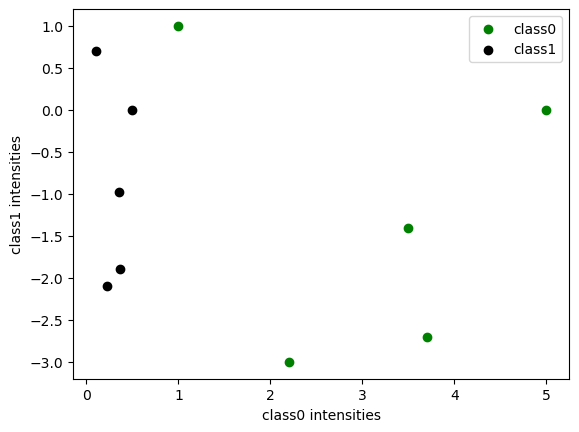

In [66]:
fig, ax = plt.subplots(1,1)
ax.scatter(class0[:,0], class0[:,1], c = 'g', label = 'class0')
ax.scatter(class1[:,0], class1[:,1], c = 'k', label = 'class1')
ax.set_xlabel('class0 intensities')
ax.set_ylabel('class1 intensities')
plt.legend()
plt.show()

In [68]:
from LDA import LDA

W = LDA(X, T)
W

array([[-4.80305983,  2.55374595, -0.29039981],
       [-0.87980561,  0.18986568, -0.36866304]])

In [70]:
Y = np.array([1,1,1]) @ W.T
Y

array([-2.53971369, -1.05860297])

In [77]:
PosteriorProb = np.clip(np.exp(Y) / np.sum(np.exp(Y)), 0, 1)
PosteriorProb

array([0.18525971, 0.81474029])